<a href="https://colab.research.google.com/github/jvataidee/pdi_python/blob/main/conversao_radiancia_de_superficie.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Conversão de Radiância para Reflectância de Superfície**

## **Criando ambiente para PDI com Python**

### Instalando Miniconda
[MINICONDA](https://docs.conda.io/en/latest/miniconda.html)

In [3]:
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local

--2023-06-27 13:23:22--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8303, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85055499 (81M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’

Miniconda3-py37_4.8 100%[===================>]  81.12M   173MB/s    in 0.5s    

2023-06-27 13:23:23 (173 MB/s) - ‘Miniconda3-py37_4.8.2-Linux-x86_64.sh’ saved [85055499/85055499]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - asn1crypto==1.3.0=py37_0
    - ca-certificates==2020.1.1=0
    - certifi==2019.11.28=py37_0
    - cffi==1.14.0=py37h2e261b9_0
    - chardet==3.0.4=py37_1003
    - conda-package-handling==1.6.0=py37h

### Definir ambiente

In [4]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

### Testando comando conda
[CONDA](https://docs.conda.io/en/latest/)

In [5]:
!conda

usage: conda [-h] [-V] command ...

conda is a tool for managing and deploying applications, environments and packages.

Options:

positional arguments:
  command
    clean        Remove unused packages and caches.
    config       Modify configuration values in .condarc. This is modeled
                 after the git config command. Writes to the user .condarc
                 file (/root/.condarc) by default.
    create       Create a new conda environment from a list of specified
                 packages.
    help         Displays a list of available conda commands and their help
                 strings.
    info         Display information about current conda install.
    init         Initialize conda for shell interaction. [Experimental]
    install      Installs a list of packages into a specified conda
                 environment.
    list         List linked packages in a conda environment.
    package      Low-level conda package utility. (EXPERIMENTAL)
    remove       Rem

### Instalando biblioteca rsgslib
[RSGISLIB](https://github.com/remotesensinginfo/rsgislib)

In [6]:
!conda install -c conda-forge rsgislib -y

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - 
CondaError: KeyboardInterrupt

^C


### Instalando biblioteca Py6s
[PY6s](https://py6s.readthedocs.io/en/latest/installation.html)

In [47]:
!conda install -c conda-forge Py6S -y

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - done


==> WARNING: A newer version of conda exists. <==
  current version: 4.14.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c conda-forge conda



# All requested packages already installed.

Retrieving notices: ...working... done


### Instalando biblioteca spectral
[SPECTRAL](https://github.com/stoplightio/spectral)

In [8]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 9.5 MB/s 
     |████████████████████████████████| 15.7 MB 46.1 MB/s 


## **Inciando o processamento**

In [159]:
import spectral
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tif
from Py6S import *
import math

### Tefinindo parâmetros

In [103]:
# Definindo o ângulo zenital solar
solar_z = 90 - 40.82290583

# Definindo a altitude
alt = 1.1

# Criando uma instância do objeto SixS
s = SixS()

# Configurando os componentes atmosféricos
s.atmos_profile = AtmosProfile.FromLatitudeAndDate(15, '2001-07-20')  # Perfil atmosférico baseado na latitude e data
s.aero_profile = AeroProfile.Continental  # Perfil de aerossóis utilizado (perfil "Continental")

# Configurando a geometria Terra-Sol-satélite
s.geometry = Geometry.User()
s.geometry.view_z = 0  # Ângulo de visada (sempre NADIR)
s.geometry.solar_z = solar_z  # Ângulo zenital solar
s.geometry.month = 7  # Mês utilizado para o cálculo da distância Terra-Sol
s.geometry.day = 20  # Dia utilizado para o cálculo da distância Terra-Sol

# Configurando as altitudes
s.altitudes.set_sensor_satellite_level()  # Altitude do sensor do satélite
s.altitudes.set_target_custom_altitude(alt)  # Altitude do alvo personalizada

In [104]:
s.run()

### Criando função de ganho

In [105]:
def fun_ganho(bandname):
    # Dicionário de seleção das bandas e seus comprimentos de onda correspondentes
    bandSelect = {
        'B1': PredefinedWavelengths.LANDSAT_ETM_B1,
        'B2': PredefinedWavelengths.LANDSAT_ETM_B2,
        'B3': PredefinedWavelengths.LANDSAT_ETM_B3,
        'B4': PredefinedWavelengths.LANDSAT_ETM_B4,
        'B5': PredefinedWavelengths.LANDSAT_ETM_B5,
        'B7': PredefinedWavelengths.LANDSAT_ETM_B7,
    }

    # Retornando o comprimento de onda correspondente à banda especificada
    return Wavelength(bandSelect[bandname])

In [106]:
s.outputs.trans

{'global_gas': <Py6S.outputs.Transmittance at 0x7fe89a13c0d0>,
 'water': <Py6S.outputs.Transmittance at 0x7fe899f22830>,
 'ozone': <Py6S.outputs.Transmittance at 0x7fe899f23520>,
 'co2': <Py6S.outputs.Transmittance at 0x7fe899f22e00>,
 'oxygen': <Py6S.outputs.Transmittance at 0x7fe89dc0f790>,
 'no2': <Py6S.outputs.Transmittance at 0x7fe89dc0f8e0>,
 'ch4': <Py6S.outputs.Transmittance at 0x7fe899e60c10>,
 'co': <Py6S.outputs.Transmittance at 0x7fe899e62410>,
 'rayleigh_scattering': <Py6S.outputs.Transmittance at 0x7fe899e62710>,
 'aerosol_scattering': <Py6S.outputs.Transmittance at 0x7fe899e612a0>,
 'total_scattering': <Py6S.outputs.Transmittance at 0x7fe89a0b8370>}

In [107]:
s.outputs.trans['total_scattering'].upward

0.83119

In [108]:
def radiancia(bandname, img):
    # Coeficientes ESUN para Landsat 7
    ESUN_L7 = [1970, 1842, 1547, 1044, 225.7, 82.06]

    # Mapeamento das bandas para os coeficientes ESUN correspondentes
    ESUN_BAND = {
        'B1': ESUN_L7[0],
        'B2': ESUN_L7[1],
        'B3': ESUN_L7[2],
        'B4': ESUN_L7[3],
        'B5': ESUN_L7[4],
        'B7': ESUN_L7[5],
    }

    # Cálculo do fator de correção angular solar
    solar_angle_correction = math.cos(solar_z) ** 2

    # Cálculo do multiplicador para converter radiância para irradiância
    multiplier = ESUN_BAND[bandname] * solar_angle_correction / (math.pi * 1.0161264 ** 2)

    # Radiância no sensor
    rad = img * multiplier

    # Configurando o comprimento de onda do SixS para a banda atual
    s.wavelength = fun_ganho(bandname)

    # Executando o modelo SixS
    s.run()

    # Extraindo as saídas do SixS
    Edir = s.outputs.direct_solar_irradiance  # Irradiância solar direta
    Edif = s.outputs.diffuse_solar_irradiance  # Irradiância solar difusa
    Lp = s.outputs.atmospheric_intrinsic_radiance  # Radiância de caminho
    absorb = s.outputs.trans['global_gas'].upward  # Transmitância de absorção
    scatter = s.outputs.trans['total_scattering'].upward  # Transmitância de espalhamento
    tau2 = absorb * scatter  # Transmitância total

    # Conversão da radiância para reflectância de superfície
    ref = ((rad - Lp) * math.pi) / (tau2 * (Edir + Edif))

    return ref

In [109]:
# Transmitância de espalhamento total
s.outputs.trans['total_scattering'].upward

0.83119

In [110]:
# Transmitância de gás global
s.outputs.trans['global_gas'].upward

0.99283

In [111]:
# Irradiância solar direta
s.outputs.direct_solar_irradiance

421.319

In [112]:
# Irradiância solar difusa
s.outputs.diffuse_solar_irradiance

449.177

### Importando Imagens

In [127]:
L7 = tif.imread(r'/content/drive/MyDrive/pdi_python/21 - PDI com Python/01 - Pré-Processamento/L71221071_07120010720_DN.tif')

In [128]:
L7.shape

(6, 1233, 1520)

In [115]:
# Criando a lista de bandas
lista_bandas = ['B1', 'B2', 'B3', 'B4', 'B5', 'B7']

In [141]:
# Criando um array vazio com a mesma forma (shape) da imagem L7
f = np.zeros_like(L7)

# Iterando sobre as bandas da imagem L7
for i in range(L7.shape[0]):
    # Chamando a função radiancia para calcular a reflectância de superfície para a banda atual
    f[i, :, :] = radiancia(lista_bandas[i], L7[i, :, :])

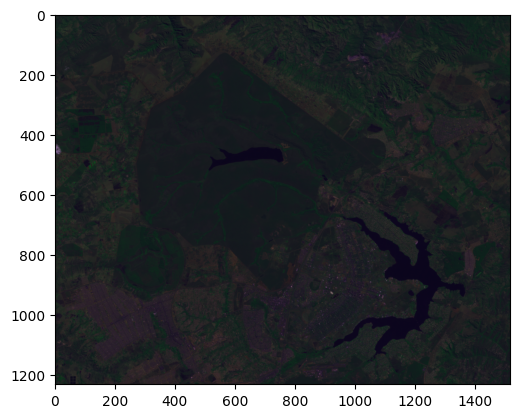

In [156]:
# Selecionando as bandas para o plot RGB
band_r = f[2, :, :]  # Banda 3 (vermelho)
band_g = f[1, :, :] # Banda 2 (verde)
band_b = f[0, :, :]  # Banda 1 (azul)
band_nir = f[3, :, :]  # Banda 3 (niir)

# Criando a imagem RGB combinando as bandas
rgb_image = np.stack((band_r, band_nir, band_b), axis=-1)

# Exibindo a primeira banda da imagem f
plt.imshow(rgb_image)
plt.show()

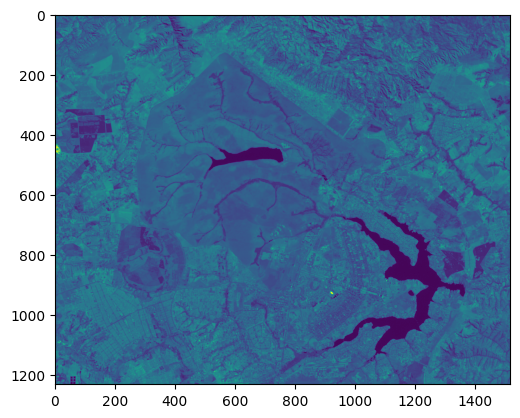

In [157]:
# Exibindo a primeira banda da imagem f
plt.imshow(f[4, :, :])
plt.show()

/usr/local/lib/python3.7/site-packages/spectral/graphics/spypylab.py:719: UserWarning: ImageView.show should only be called once.
  warnings.warn(UserWarning(msg))


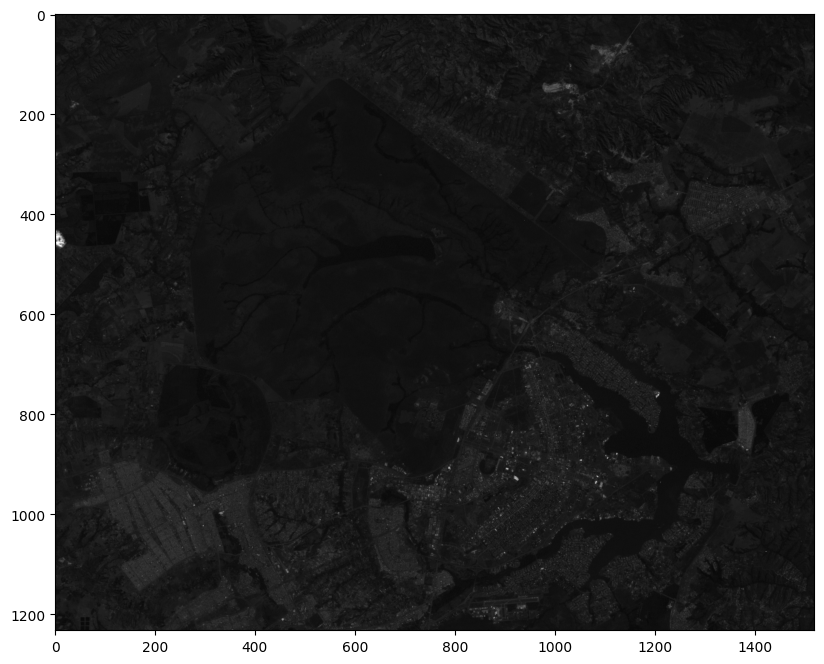

In [161]:
# Criando um objeto ImageView
view = spectral.imshow(f[0, :, :], bands=[0], figsize=(12, 8))
view.show()

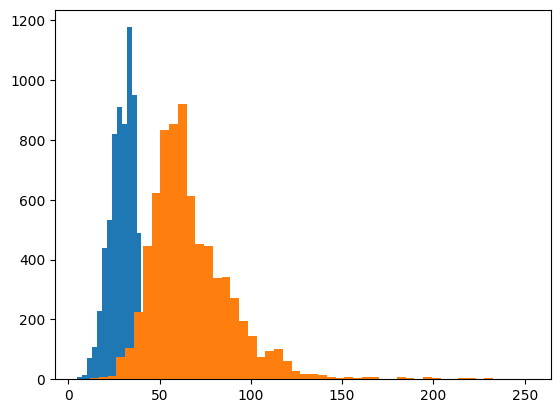

In [155]:
# Criação do histograma para a banda de reflectância de superfície (f)
plt.hist(f[:, :, 0].flatten(), bins=50)

# Criação do histograma para a banda original da imagem Landsat (L7)
plt.hist(L7[:, :, 0].flatten(), bins=50)

# Exibição dos histogramas
plt.show()